In [5]:
# Data:
import pandas as pd
import numpy as np
from scipy.stats import norm
import datetime
import re

# Modelling:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

# Visualize:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Ipython:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
###############
# Import Data #
###############

PATH = "../Train.csv"

# Einlesen: 401125 rows × 53 columns
NROWS = 40000
df_raw = pd.read_csv(PATH, low_memory=False, nrows=NROWS, parse_dates=["saledate"])
print ("Shape df_raw: ", df_raw.shape)
print("")

# Save "Id" column
#train_ID = train_data["Id"]
# Drop "Id" column
#train_data = train_data.drop("Id", axis = 1)

#print("df_raw: info:")
#print(df_raw.info())
#print("")
#print("df_raw: describe:")
#print(df_raw.describe())
#print("")
#print("Share of nan:")
#print(df_raw.isna().sum() / df_raw.shape[0])

df_raw.head(5)

Shape df_raw:  (40000, 53)



,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
################
# Missing Data #
################

def top_nans (df):
    df = (df.isnull().sum() / len(df)) * 100
    df = pd.DataFrame({"Missing Ratio" :df}).sort_values(by=["Missing Ratio"], ascending=False)
    return df

df_nan = top_nans(df_raw)
df_nan.head(10)

,Missing Ratio
Enclosure_Type,96.2675
Blade_Width,96.2675
Blade_Extension,96.2675
Pushblock,96.2675
Scarifier,96.2675
Tip_Control,96.2675
Engine_Horsepower,96.2675
fiModelSeries,90.4425
Backhoe_Mounting,86.8575
Travel_Controls,86.7475


In [6]:
#######################
# Feature Engineering #
#######################

def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    # Parsen des Datums falls noch nicht geschehen
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    # ordentliche Benennung des Datums
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        # Extrahiert für jedes Datum eine Eigenschaft (siehe Liste oben)
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    # Zeit in Millisekunden seit Unix
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)
        
add_datepart(df_raw, "saledate")
print (df_raw.shape)
df_raw.head(5)

(40000, 65)


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,66000,999089,3157,121,3,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,57000,117657,77,121,3,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,10000,434808,7009,121,3,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,38500,1026470,332,121,3,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,11000,1057373,17311,121,3,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


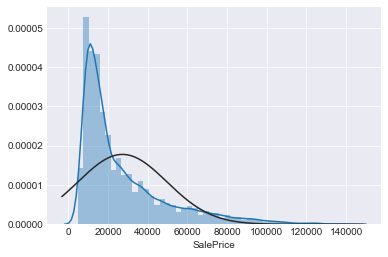

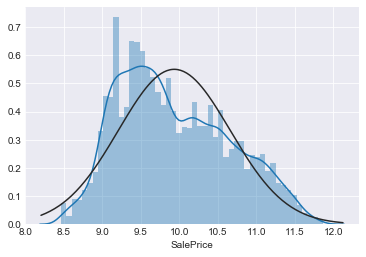

In [7]:
###########################
# Schiefe Target Variable #
###########################

# Target Variable ist rechts-schief:
sns.distplot(df_raw["SalePrice"] , fit=norm)
plt.show()

# Log-Transformation der Target-Variable und Drop aus df_raw
y = np.log1p(df_raw["SalePrice"])
df_raw = df_raw.drop(["SalePrice"], axis=1)

# Re-check der neuen Verteilung: 
sns.distplot(y , fit=norm)
plt.show()

In [8]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelBinarizer, Imputer

# Gibt passenden dataframe zurück (siehe unten)
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X[self.attribute_names]
        X = pd.DataFrame(X)
        return X
    def get_feature_names(self):
        return X.columns.tolist()

# Ersetzt alle numerics mit median (hyperparameter zum tunen) und zusätzliche Spalte mit Wert falls ersetzt
class num_imputer_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        print ("vor zusätzlichen columns im imputer", X.shape)
        for i in X.columns:
            if pd.isnull(X[i]).sum(): 
                X[i+"_na"] = pd.isnull(X[i])
        print ("nach zusätzlichen columns im imputer", X.shape)
        imputer = Imputer(strategy="median")
        X = imputer.fit_transform(X)
        X = pd.DataFrame(X)
        print ("imputer_Transformer shape", X.shape)
        print ("")
        return X

# Skalieren aller numerischen Werte von X: -> Macht das überhaupt sinn?!
class standardScaler_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
        for i in X.columns:
            scaled = X[[i]]
            scaled = scaler.fit_transform(scaled)
            X[[i]] = scaled
        X = pd.DataFrame(X)
        print ("standardScaler_Transformer shape", X.shape)
        print ("")
        return X

# Kodiert kategorische Variablen in 0, 1, 2 etc.
class encoder_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        encoder = LabelEncoder()
        for i in X.columns:
            encoded = X[i]
            encoded = encoder.fit_transform(encoded.astype(str))
            X[i] = encoded
        print ("encoder_Transformer shape", X.shape)
        print ("")
        return X  

# Wählt gibt passenden dataframe zurück
objects = list(df_raw.select_dtypes(include=["object"]))
numerics = list(df_raw.select_dtypes(exclude=["object"]))

num_pipeline = Pipeline([
    ("data", DataFrameSelector(numerics)),
    ("impute", num_imputer_Transformer()),
    ("scale", standardScaler_Transformer())
])
ob_pipeline = Pipeline([
    ("data", DataFrameSelector(objects)),
    ("labels", encoder_Transformer())
])
combined_features = FeatureUnion([("num", num_pipeline), ("ob", ob_pipeline)])

data_prepared = pd.DataFrame(combined_features.fit_transform(df_raw))
print ("data_prepared shape", data_prepared.shape)
data_prepared.head(5)

vor zusätzlichen columns im imputer (40000, 20)
nach zusätzlichen columns im imputer (40000, 21)
imputer_Transformer shape (40000, 21)

standardScaler_Transformer shape (40000, 21)

encoder_Transformer shape (40000, 44)

data_prepared shape (40000, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-1.625964,-0.101919,-0.618897,-0.817603,-0.184936,0.421985,-0.784006,0.194618,1.281949,1.283681,...,18.0,22.0,3.0,3.0,2.0,2.0,10.0,7.0,2.0,1.0
1,-1.625920,-2.658314,-1.096095,-0.817603,-0.184936,0.398688,0.167237,-0.134943,-1.083325,-0.982429,...,18.0,22.0,3.0,3.0,2.0,2.0,10.0,7.0,2.0,1.0
2,-1.625898,-1.738489,-0.022090,-0.817603,-0.184936,0.413249,-0.207684,-0.134943,-1.378984,-1.257109,...,18.0,22.0,3.0,3.0,2.0,2.0,10.0,7.0,3.0,3.0
3,-1.625855,-0.022506,-1.056587,-0.817603,-0.184936,0.413249,-0.072862,1.018520,-0.492006,-0.501739,...,18.0,22.0,3.0,3.0,2.0,2.0,10.0,7.0,3.0,3.0
4,-1.625811,0.067121,1.574044,-0.817603,-0.184936,0.430721,-0.647936,0.688959,0.099312,0.184961,...,18.0,22.0,3.0,3.0,2.0,2.0,10.0,7.0,3.0,3.0


In [11]:
###########################################
#  Randomized Grid Search: Random Forest  #
###########################################

t1 = datetime.datetime.now().replace(microsecond=0)

# Random Forest Regressor: alle Kerne nutzen
forest_reg = RandomForestRegressor(n_jobs=-1)

#Best rmse:
#0.30134876026346435
#Best Params:
#{'n_estimators': 40, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30}
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 120, num = 12)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(start = 5, stop = 30, num = 6)],
               'min_samples_split': [2, 5, 10, 15, 100],
               'min_samples_leaf': [1, 2, 3, 5,]}

SEARCHES = 30
#SEARCHES = 1
random_search = RandomizedSearchCV(forest_reg, param_distributions = random_grid, n_iter=SEARCHES, scoring="neg_mean_squared_error")
random_search.fit(data_prepared, y)
print("Searches:", SEARCHES)
print ("Zeit: ", datetime.datetime.now().replace(microsecond=0)-t1)
print("")
print("Best rmse:")
print(np.sqrt(-random_search.best_score_))
print("")
print("Best Params:")
print(random_search.best_params_)

Searches: 30
Zeit:  0:02:57

Best rmse:
0.30134876026346435

Best Params:
{'n_estimators': 40, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30}


In [15]:
################
#  Submission  #
################

# RandomForest: 80/475 ; 0.3013 (Top 17%)

# Import der Test-Daten
PATH = "../Test.csv"
test_data = pd.read_csv(PATH, low_memory=False, parse_dates=["saledate"])

# Data Processing der Test-Daten
add_datepart(test_data, "saledate")
SalesID = test_data.SalesID
test_data_prepared = pd.DataFrame(combined_features.fit_transform(test_data))

# Prediction:
y_pred = pd.DataFrame(np.expm1(random_search.predict(test_data_prepared.values)))

# Submission File:
submission = pd.concat([SalesID, y_pred], axis=1, ignore_index=True)
submission.columns = ["SalesID", "SalePrice"]
submission.to_csv("submission.csv",index=False)
submission.head(5)

vor zusätzlichen columns im imputer (12457, 20)
nach zusätzlichen columns im imputer (12457, 21)
imputer_Transformer shape (12457, 21)

standardScaler_Transformer shape (12457, 21)

encoder_Transformer shape (12457, 44)



,SalesID,SalePrice
0,1227829,17596.882404
1,1227844,22286.514413
2,1227847,46140.767825
3,1227848,63249.610166
4,1227863,30205.648124
